## Imports

In [12]:
import gymnasium as gym
import os

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

from Environment import MarioPyBoyEnv
from pyboy import PyBoy

## RL Learning

### Create Environments / Model

In [7]:
#Hyper Parameters
MAX_EPISODES = 20000
SCORES = []

LEARNING_RATE = 0.0003

BUFFER_SIZE = 1000000
LEARNING_START = 1000
BATCH_SIZE = 128
UPDATE_FREQUENCY = 100
TRAIN_FREQ = 1
GRADIENT_STEPS = 1

N_STEPS = 128                        # Number of steps to run in the environment per update
GAMMA = 0.99                         # Discount factor for future rewards
ENT_COEF = 0.01                      # Coefficient for the entropy term (encourages exploration)
VF_COEF = 0.5                        # Coefficient for the value function loss
MAX_GRAD_NORM = 0.5

### Charting Callback

In [8]:
class ChartingCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, scores, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards_list = scores
        self.episode_reward = 0
        self.episode = 0
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env # type: VecEnv
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # num_timesteps = n_envs * n times env.step() was called
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = {}  # type: Dict[str, Any]
        # self.globals = {}  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger # type: stable_baselines3.common.logger.Logger
        # Sometimes, for event callback, it is useful
        # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        # Accumulate rewards for the current episode
        self.episode_reward += self.locals["rewards"][0]

        # Check if the episode is done
        if self.locals["dones"][0]:
            # Append the total reward for this episode to the external list
            self.episode_rewards_list.append(self.episode_reward)
            #Print
            print(f"Episode {self.episode}:      Score {self.episode_reward}")
            # Reset episode reward for the next episode
            self.episode_reward = 0
            self.episode+=1

        return True

In [9]:
# Create environment
supermarioland_rom = "SuperMarioLand_rom.gb"
pyboy = PyBoy(supermarioland_rom)
env = MarioPyBoyEnv(pyboy, debug=True)

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=0, learning_rate=LEARNING_RATE,
            gamma=GAMMA,ent_coef=ENT_COEF,vf_coef=VF_COEF,
            n_epochs=10)
        
# Stops training when the model reaches the maximum number of episodes
callback_max_episodes = StopTrainingOnMaxEpisodes(max_episodes=MAX_EPISODES)
charting_rewards = ChartingCallback(SCORES)

### Learn

In [11]:
# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e10), callback=[callback_max_episodes, charting_rewards])
# Save the agent
model.save("MarioLand")

Step
Episode 689:      Score 0.0
Step
Episode 690:      Score 0.0
Step
Episode 691:      Score 0.0
Step
Episode 692:      Score 0.0
Step
Episode 693:      Score 0.0
Step
Episode 694:      Score 0.0
Step
Episode 695:      Score 0.0
Step
Episode 696:      Score 0.0
Step
Episode 697:      Score 0.0
Step
Episode 698:      Score 0.0
Step
Episode 699:      Score 0.0
Step
Episode 700:      Score 0.0
Step
Episode 701:      Score 0.0
Step
Episode 702:      Score 0.0
Step
Episode 703:      Score 0.0
Step
Episode 704:      Score 0.0
Step
Episode 705:      Score 0.0
Step
Episode 706:      Score 0.0
Step
Episode 707:      Score 0.0
Step
Episode 708:      Score 0.0
Step
Episode 709:      Score 0.0
Step
Episode 710:      Score 0.0
Step
Episode 711:      Score 0.0
Step
Episode 712:      Score 0.0
Step
Episode 713:      Score 0.0
Step
Episode 714:      Score 0.0
Step
Episode 715:      Score 0.0
Step
Episode 716:      Score 0.0
Step
Episode 717:      Score 0.0
Step
Episode 718:      Score 0.0
Step
Episo

KeyboardInterrupt: 

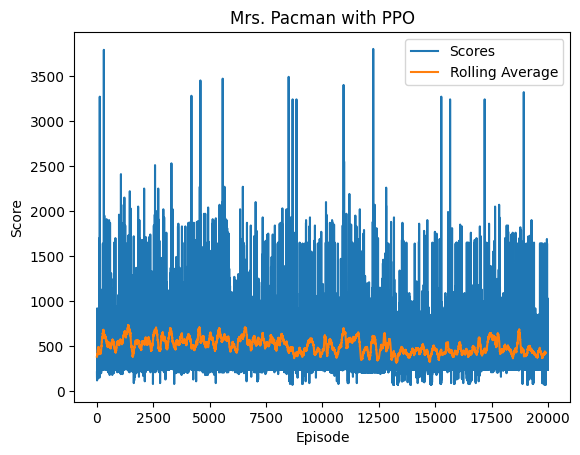

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

#plotting
x = range(0,len(SCORES))
ravg = running_mean(SCORES,100)
x2 = range(0,len(ravg))
plt.plot(x, SCORES, label="Scores")
plt.plot(x2, ravg, label="Rolling Average")
plt.plot()

plt.xlabel("Episode")
plt.ylabel("Score")
plt.title(f"Mrs. Pacman with PPO")
plt.legend()
plt.show()

### Load Model

In [ ]:
'''
# Load the trained agent
# NOTE: if you have loading issue, you can pass `print_system_info=True`
# to compare the system on which the model was trained vs the current one
# model = A2C.load("dqn_lunar", env=env, print_system_info=True)
model = A2C.load("dqn_lunar", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

# Enjoy trained agent
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")
    if done:
        obs = env.reset()

env.close()
'''

'\n# Load the trained agent\n# NOTE: if you have loading issue, you can pass `print_system_info=True`\n# to compare the system on which the model was trained vs the current one\n# model = A2C.load("dqn_lunar", env=env, print_system_info=True)\nmodel = A2C.load("dqn_lunar", env=env)\n\n# Evaluate the agent\n# NOTE: If you use wrappers with your environment that modify rewards,\n#       this will be reflected here. To evaluate with original rewards,\n#       wrap environment in a "Monitor" wrapper before other wrappers.\nmean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)\n\n# Enjoy trained agent\nvec_env = model.get_env()\nobs = vec_env.reset()\nfor i in range(500):\n    action, _states = model.predict(obs, deterministic=True)\n    obs, rewards, dones, info = vec_env.step(action)\n    vec_env.render("human")\n    if done:\n        obs = env.reset()\n\nenv.close()\n'